# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc



In [2]:
data = pd.read_csv('data/spam.csv',header=None, sep='\t', names=['label','email'])
data.head(2)

,label,email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [3]:
# рассчитайте частоты для классов 
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

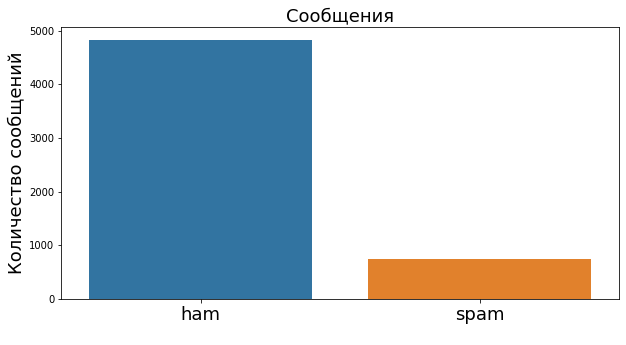

In [4]:
# визуализируйте результат
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=data, x='label')
ax.set_title('Сообщения', fontsize = 18)
ax.set_ylabel('Количество сообщений', fontsize = 18)
ax.set_xlabel(' ')
ax.set_xticks(ticks=[0,1], labels=['ham', 'spam'], fontsize = 18)
plt.show()

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
data['label']=data['label'].apply(lambda x: 1 if x == 'spam' else 0)
data

,label,email
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [6]:
data = data.replace ( r'^\s\*$' , np.nan , regex= True )
data.dropna(inplace=True)

Переводим данные в векторный вид:

In [7]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [8]:
X.shape[1]

8713

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [9]:
X = X.toarray()
y = data['label']

Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.25, random_state=42)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [11]:
y_test.mean()

0.1342426417803302

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [12]:
nbc = ComplementNB(alpha=0.01)
nbc.fit(X_train, y_train)

ComplementNB(alpha=0.01)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [13]:
y_test_pred = nbc.predict(X_test)
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.992     0.979     0.985      1206
           1      0.876     0.947     0.910       187

    accuracy                          0.975      1393
   macro avg      0.934     0.963     0.948      1393
weighted avg      0.976     0.975     0.975      1393



Нарисуйте ROC-кривую:

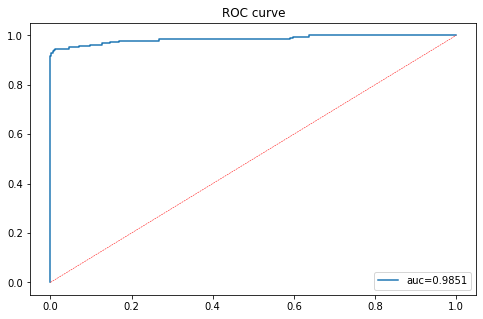

In [14]:
y_pred_proba = nbc.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(fpr,tpr,label="auc="+str(round(auc,4)))
ax.plot([0, 1], [0, 1],'r--', lw=0.5)
plt.title('ROC curve')
plt.legend()
plt.show()

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

Кросс-валидация, среднее значение метрики по 5 фолдам
alpha = 0.001; f1-score = 0.910
alpha = 0.010; f1-score = 0.907
alpha = 0.100; f1-score = 0.893
alpha = 1.000; f1-score = 0.888
alpha = 3.000; f1-score = 0.884
alpha = 5.000; f1-score = 0.868


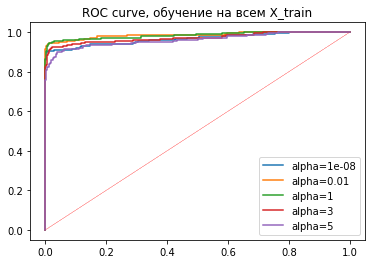

In [15]:
print('Кросс-валидация, среднее значение метрики по 5 фолдам')
a = [0.001, 0.01, 0.1, 1, 3, 5]
for alpha in a:
    nbc = ComplementNB(alpha=alpha)
    f1_score = cross_val_score(nbc, X_train, y_train, cv=5, scoring='f1').mean()
    
    print('alpha = {:.3f}; f1-score = {:.3f}'.format(
        alpha, f1_score ))
    
    #визуализация влияния параметра alfa    
for alpha in [1e-8, 0.01, 1, 3, 5]:
    nbc = ComplementNB(alpha=alpha)    
    nbc.fit(X_train, y_train)
    y_pred_proba = nbc.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr,tpr,label="alpha="+str(alpha))
    plt.plot([0, 1], [0, 1],'r--', lw=0.1)
    plt.title('ROC curve, обучение на всем X_train')
    plt.legend()

Качество классификации зависит от alpha. Можно найти оптимальное значение.